# **Libraries**
Pustaka utama yang digunakan adalah tensorflow2, keras , numpy dan pandas

In [299]:
#importing the libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import nltk
import pickle
from keras.utils.vis_utils import plot_model
from keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, GlobalMaxPooling1D, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# **Importing the Data**
Data disimpan dalam file json, yang dapat diimpor dan digunakan sebagai kerangka data panda. Data ini dibuat secara manual oleh saya. karenanya, tidak sebesar itu.
kita semua tahu bahwa pembelajaran mendalam membutuhkan potongan data yang besar. tapi, bukan itu masalahnya di sini. Saya telah menggunakan arsitektur jaringan saraf yang cukup kuat untuk menangani data dalam jumlah kecil ini

In [300]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [301]:
#importing the dataset
with open('dataset1.json') as content:
  data1 = json.load(content)

In [302]:
#getting all the data to lists
tags = []
inputs = []
responses={}
for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])

In [303]:
#converting to dataframe
data = pd.DataFrame({"patterns":inputs,
                     "tag":tags})

In [304]:
#printing the data
data

,patterns,tag
0,halo,menyapa
1,hei,menyapa
2,hai,menyapa
3,"hai, apakah ini layanan informasi tugas akhir",menyapa
4,"hei, apakah ini layanan informasi tugas akhir",menyapa
...,...,...
978,Apa langkah selanjutnya setelah menyelesaikan ...,sebelum_pengajuan
979,Bagaimana cara melanjutkan setelah menyelesaik...,sebelum_pengajuan
980,Apa tindakan yang sebaiknya diambil setelah me...,sebelum_pengajuan
981,Apa yang perlu dikerjakan setelah menyelesaika...,sebelum_pengajuan


In [305]:
data = data.sample(frac=1)

In [306]:
print("Total number of patterns:", len(data))
print("Total number of unique tags:", len(data['tag'].unique()))

Total number of patterns: 983
Total number of unique tags: 27


# **Pre-Processing**
Pra-pemrosesan penting seperti menghapus tanda baca, mengonversi ke huruf kecil, menyandikan data tekstual menjadi data numerik telah selesai

In [307]:
#removing punctuations
import string
data['patterns'] = data['patterns'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['patterns'] = data['patterns'].apply(lambda wrd: ''.join(wrd))
data

,patterns,tag
143,apa persyaratan administratif yang harus terpe...,administrasi
569,persyaratan sebelum seminar kemajuan apa saja,sebelum_seminar_kemajuan
274,bagaimana cara menyusun tugas akhir dengan benar,tahapan
789,bagaimana proses setelah mengikuti sidang dan ...,pasca_sidang
973,setelah menyelesaikan penulisan proposal ta at...,sebelum_pengajuan
...,...,...
800,bagaimana cara mendaftar wisuda,wisuda
691,bagaimana rencana tindakan yang harus diambil ...,ketentuan_seminar_kemajuan_tidak_lulus
840,apa yang harus dikelola sebelum dapat hadir da...,wisuda
808,bagaimana tata cara mendaftar dan memenuhi sya...,wisuda


In [308]:
#tokenize the data
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['patterns'])
train = tokenizer.texts_to_sequences(data['patterns'])

#apply padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(train)

#encoding the outputs
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(data['tag'])
y_test = le.transform(data['tag'])

In [309]:
input_shape = x_train.shape[1]
print(input_shape)

19


In [310]:
#define vocabulary
vocabulary = len(tokenizer.word_index)
print("number of unique words : ",vocabulary)
output_length = le.classes_.shape[0]
print("output length: ",output_length)

number of unique words :  538
output length:  27


In [311]:
pickle.dump(le, open('le.pickle','wb'))
pickle.dump(tokenizer, open('tokenizers.pickle','wb'))

# **Neural Network**
Jaringan terdiri dari lapisan embedding yang merupakan salah satu hal paling kuat di bidang pemrosesan bahasa alami. output dari embedding layer adalah input dari reccurent layer dengan lstm gate. kemudian, keluarannya diratakan dan lapisan padat biasa digunakan dengan fungsi aktivasi softmax.

Bagian utama adalah lapisan embedding yang memberikan vektor yang sesuai untuk setiap kata dalam dataset

In [312]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [313]:
from nltk.util import flatten
#creating the model

i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1,10)(i)
x = LSTM(10,return_sequences=True)(x)
x = Flatten()(x)
x = Dense(output_length,activation="softmax")(x)
model  = Model(i,x)

#compiling the model
model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

In [314]:
# Mengakses learning rate dari optimizer
learning_rate = model.optimizer.lr.numpy()

# Mencetak learning rate
print("Current learning rate:", learning_rate)

Current learning rate: 0.001


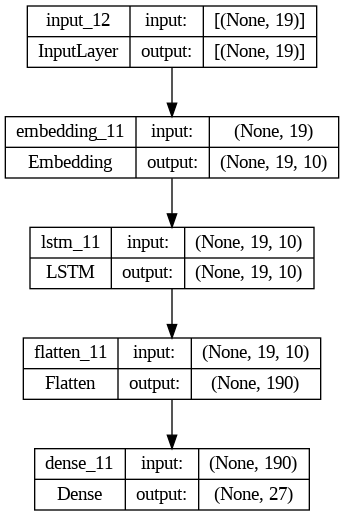

In [315]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [316]:
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 19)]              0         
                                                                 
 embedding_11 (Embedding)    (None, 19, 10)            5390      
                                                                 
 lstm_11 (LSTM)              (None, 19, 10)            840       
                                                                 
 flatten_11 (Flatten)        (None, 190)               0         
                                                                 
 dense_11 (Dense)            (None, 27)                5157      
                                                                 
Total params: 11,387
Trainable params: 11,387
Non-trainable params: 0
_________________________________________________________________


In [317]:
#training the model
#train = model.fit(x_train,y_train,epochs=300)
train = model.fit(x_train, y_train, epochs=150, validation_data=(x_test, y_test))

Epoch 1/150
25/25 [==============================] - 3s 33ms/step - loss: 3.2778 - accuracy: 0.0394 - val_loss: 3.2417 - val_accuracy: 0.0761
Epoch 2/150
25/25 [==============================] - 0s 14ms/step - loss: 3.2108 - accuracy: 0.0700 - val_loss: 3.2048 - val_accuracy: 0.0711
Epoch 3/150
25/25 [==============================] - 0s 11ms/step - loss: 3.1837 - accuracy: 0.0700 - val_loss: 3.1998 - val_accuracy: 0.0711
Epoch 4/150
25/25 [==============================] - 0s 14ms/step - loss: 3.1529 - accuracy: 0.0700 - val_loss: 3.1612 - val_accuracy: 0.0711
Epoch 5/150
25/25 [==============================] - 0s 11ms/step - loss: 3.1089 - accuracy: 0.0941 - val_loss: 3.1032 - val_accuracy: 0.1066
Epoch 6/150
25/25 [==============================] - 0s 13ms/step - loss: 3.0200 - accuracy: 0.1272 - val_loss: 3.0070 - val_accuracy: 0.1269
Epoch 7/150
25/25 [==============================] - 0s 13ms/step - loss: 2.8942 - accuracy: 0.2074 - val_loss: 2.8677 - val_accuracy: 0.2234
Epoch 

# **Model Analysis**

In [318]:
model.save('trained_model.h5')

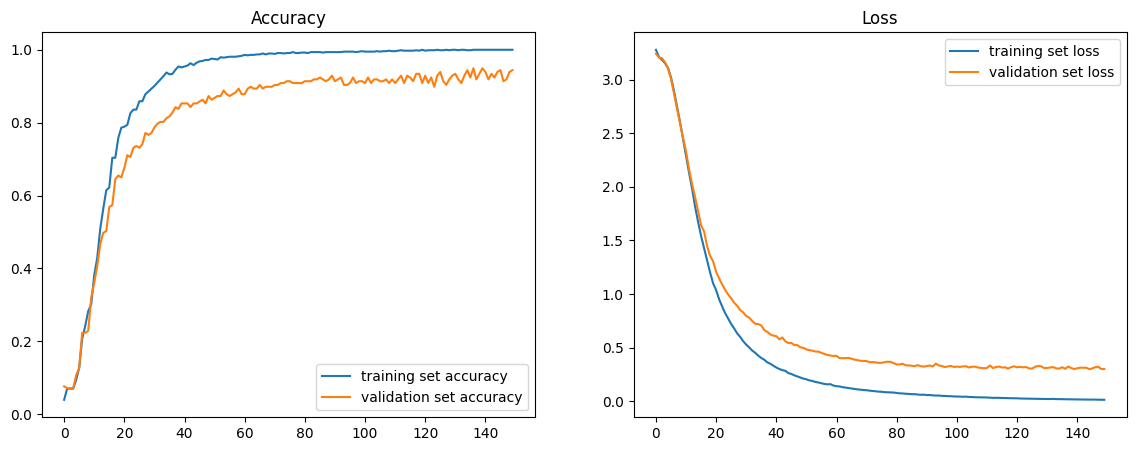

In [319]:
#plotting model accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train.history['accuracy'], label='training set accuracy')
plt.plot(train.history['val_accuracy'], label='validation set accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

#plot Loss
plt.subplot(1, 2, 2)
plt.plot(train.history['loss'], label='training set loss')
plt.plot(train.history['val_loss'], label='validation set loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [320]:
# Calculate metrics and confusion matrix
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
class_names = le.classes_

print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=1))

7/7 [==============================] - 0s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.92      1.00      0.96        12
           2       1.00      0.67      0.80         3
           3       1.00      1.00      1.00        17
           4       1.00      0.90      0.95        10
           5       0.93      1.00      0.97        14
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         7
           9       0.40      1.00      0.57         2
          10       1.00      0.82      0.90        11
          11       0.92      1.00      0.96        12
          12       0.67      1.00      0.80         2
          13       1.00      1.00      1.00        14
          14       1.00      1.00      1.00        10
          15       0.90      0.82      0.86        11
       

In [321]:
# Menghitung dan mencetak akurasi, presisi, dan recall
akurasi = accuracy_score(y_test, y_pred)
presisi = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)

print(f"Akurasi pada data uji: {akurasi}")
print(f"Presisi pada data uji: {presisi}")
print(f"Recall pada data uji: {recall}")

Akurasi pada data uji: 0.9441624365482234
Presisi pada data uji: 0.9563284431304737
Recall pada data uji: 0.9441624365482234


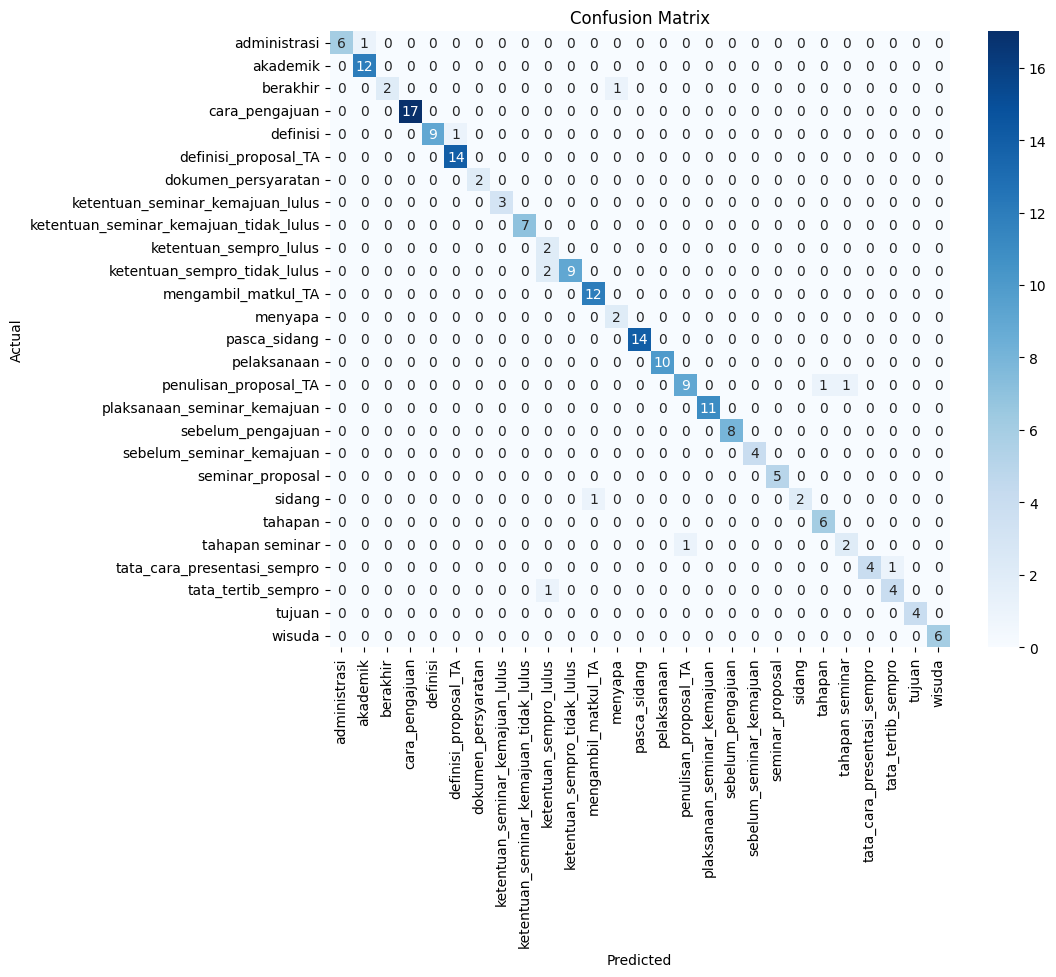

In [322]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# **Testing**
Saya juga telah menguji model dengan cara meniru interaksi manusia dengan bot dan mendapatkan hasil yang positif. namun, Ini sangat sederhana karena jumlah data yang saya buat sangat kecil. namun, model yang sama juga dapat digunakan dengan jumlah data yang besar

In [323]:
#chatting
import random


while True:
  texts_p = []
  prediction_input = input('You : ')

  #removing punctuation and converting to lowercase
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  #tokenizing and padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape)

  #getting output from model
  output = model.predict(prediction_input)
  output = output.argmax()

  #finding the right tag and predicting
  response_tag = le.inverse_transform([output])[0]
  print("chatbot : ",random.choice(responses[response_tag]))

KeyboardInterrupt: ignored